<a href="https://colab.research.google.com/github/FabioSicca/Organizacion-de-datos/blob/main/Parte4_TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Parte IV - Machine Learning (5 puntos)

Entrenar un nuevo modelo (que no sea Random Forest ni el utilizado para el baseline) con búsqueda de hiperparametros (¿cómo conviene elegir los datos de validación respecto de los de train?). El modelo debe cumplir las siguientes condiciones:

* Deben utilizar AUC-ROC como métrica de validación.
* Deben medirse solo en validación, no contra test!!!
* Deben ser reproducibles (correr el notebook varias veces no afecta al resultado).
* Deben tener un score en validación superior a 0,9.
* Para el feature engineering debe utilizarse imputación de nulos, mean encoding y one hot encoding al menos una vez cada uno.
* Deben utilizar al menos 40 features (contando cómo features columnas con números, pueden venir varios de la misma variable).
* Deberán contestar la siguientes preguntas:

¿Cuál es el score en test? (guardar el csv con predicciones para entregarlo después)

¿Por qué cree que logro/no logro el mismo valor de AUC que con Random Forest?

In [ ]:
import pandas as pd
import numpy as np

!pip install category_encoders
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from category_encoders.binary import BinaryEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

!pip install scikit-plot
import scikitplot as skplt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/secondary_data.csv', sep=";")

In [ ]:
X = df.drop('class', axis=1)
y = df['class']

In [ ]:
X_train_aux, X_test, y_train_aux, y_test = train_test_split(X, y, test_size=0.1, random_state=5)

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train_aux, y_train_aux, test_size=0.1, random_state=5)

In [ ]:
print(X_train.info(), X_validation.info(), X_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49465 entries, 34760 to 57712
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cap-diameter          49465 non-null  float64
 1   cap-shape             49465 non-null  object 
 2   cap-surface           37940 non-null  object 
 3   cap-color             49465 non-null  object 
 4   does-bruise-or-bleed  49465 non-null  object 
 5   gill-attachment       41413 non-null  object 
 6   gill-spacing          29137 non-null  object 
 7   gill-color            49465 non-null  object 
 8   stem-height           49465 non-null  float64
 9   stem-width            49465 non-null  float64
 10  stem-root             7755 non-null   object 
 11  stem-surface          18525 non-null  object 
 12  stem-color            49465 non-null  object 
 13  veil-type             2598 non-null   object 
 14  veil-color            6043 non-null   object 
 15  has-ring       

#Feature Engineering y Encoding

##Relleno los NaNs

###Relleno NaNs en X_train

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49465 entries, 34760 to 57712
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cap-diameter          49465 non-null  float64
 1   cap-shape             49465 non-null  object 
 2   cap-surface           37940 non-null  object 
 3   cap-color             49465 non-null  object 
 4   does-bruise-or-bleed  49465 non-null  object 
 5   gill-attachment       41413 non-null  object 
 6   gill-spacing          29137 non-null  object 
 7   gill-color            49465 non-null  object 
 8   stem-height           49465 non-null  float64
 9   stem-width            49465 non-null  float64
 10  stem-root             7755 non-null   object 
 11  stem-surface          18525 non-null  object 
 12  stem-color            49465 non-null  object 
 13  veil-type             2598 non-null   object 
 14  veil-color            6043 non-null   object 
 15  has-ring       

Con esta información puedo ver qué columnas tienen NaNs y cuántos tienen.

In [ ]:
#En cap-surface tengo 11525 NaNs y en la documentación del dataset no hace referencia a que signifique nada particular
print(X_train.groupby("cap-surface").size())
#Los relleno con una nueva categoria "Unknown"
X_train["cap-surface"] = X_train["cap-surface"].fillna("unknown")

cap-surface
d    3524
e    2112
g    3806
h    4014
i    1806
k    1852
l    1153
s    6167
t    6629
w    1753
y    5124
dtype: int64


In [ ]:
#gill-attachment (8052 NaNs)
print(X_train.groupby("gill-attachment").size())
#Los relleno con "Unknown"
X_train["gill-attachment"] = X_train["gill-attachment"].fillna("unknown")

gill-attachment
a    10279
d     8281
e     4591
f     2862
p     4805
s     4590
x     6005
dtype: int64


In [ ]:
#gill-spacing (20328 NaNs)
print(X_train.groupby("gill-spacing").size())
X_train["gill-spacing"] = X_train["gill-spacing"].fillna("unknown")

gill-spacing
c    20024
d     6251
f     2862
dtype: int64


In [ ]:
#stem-root (41710 NaNs)
print(X_train.groupby("stem-root").size())
X_train["stem-root"] = X_train["stem-root"].fillna("unknown")

stem-root
b    2602
c     568
f     848
r    1144
s    2593
dtype: int64


In [ ]:
#stem-surface (30940 NaNs)
print(X_train.groupby("stem-surface").size())
X_train["stem-surface"] = X_train["stem-surface"].fillna("unknown")

stem-surface
f     848
g    1438
h     424
i    3535
k    1266
s    4862
t    2143
y    4009
dtype: int64


In [ ]:
#veil-type (46867 NaNs) Dado que solo hay de tipo u=universal, se asume que los NaNs=partial por lo que se reemplazan con p
print(X_train.groupby("veil-type").size())
X_train["veil-type"] = X_train["veil-type"].fillna("p")

veil-type
u    2598
dtype: int64


In [ ]:
#veil-color (43422 NaNs) Como según el dataset f=none, NaN podría ser Unknown
print(X_train.groupby("veil-color").size())
X_train["veil-color"] = X_train["veil-color"].fillna("unknown")

veil-color
e     151
k     292
n     416
u     286
w    4465
y     433
dtype: int64


In [ ]:
#ring-type (1974 NaNs) Como f representa casi el total, puedo reemplazar los "pocos" faltantes por f,
#además el dataset indica que los NaNs hacen referencia a que no se sabe el tipo de dato, por lo que no está mal rellenarlo.
print(X_train.groupby("ring-type").size())
X_train["ring-type"] = X_train["ring-type"].fillna("f")

ring-type
e     1959
f    39108
g     1025
l     1165
m      292
p     1035
r     1155
z     1711
dtype: int64


In [ ]:
#spore-print-color (44316 NaNs)
print(X_train.groupby("spore-print-color").size())
#Podria intentar rellenarlo aleatoriamente con fillna(method='ffill'), pero hay demasiados NaNs, por lo que uso "unknown"
X_train["spore-print-color"] = X_train["spore-print-color"].fillna("unknown")

spore-print-color
g     294
k    1715
n     852
p    1013
r     140
u     152
w     983
dtype: int64


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49465 entries, 34760 to 57712
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cap-diameter          49465 non-null  float64
 1   cap-shape             49465 non-null  object 
 2   cap-surface           49465 non-null  object 
 3   cap-color             49465 non-null  object 
 4   does-bruise-or-bleed  49465 non-null  object 
 5   gill-attachment       49465 non-null  object 
 6   gill-spacing          49465 non-null  object 
 7   gill-color            49465 non-null  object 
 8   stem-height           49465 non-null  float64
 9   stem-width            49465 non-null  float64
 10  stem-root             49465 non-null  object 
 11  stem-surface          49465 non-null  object 
 12  stem-color            49465 non-null  object 
 13  veil-type             49465 non-null  object 
 14  veil-color            49465 non-null  object 
 15  has-ring       

Entonces ahora se puede ver que el dataset X_train ya no tiene valores NaNs

### Relleno los NaNs en X_validation

In [ ]:
X_validation["cap-surface"] = X_validation["cap-surface"].fillna("unknown")
X_validation["gill-attachment"] = X_validation["gill-attachment"].fillna("unknown")
X_validation["gill-spacing"] = X_validation["gill-spacing"].fillna("unknown")
X_validation["stem-root"] = X_validation["stem-root"].fillna("unknown")
X_validation["stem-surface"] = X_validation["stem-surface"].fillna("unknown")
X_validation["veil-type"] = X_validation["veil-type"].fillna("p")
X_validation["veil-color"] = X_validation["veil-color"].fillna("unknown")
X_validation["ring-type"] = X_validation["ring-type"].fillna("f")
X_validation["spore-print-color"] = X_validation["spore-print-color"].fillna("unknown")

In [ ]:
X_validation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5497 entries, 35132 to 58126
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cap-diameter          5497 non-null   float64
 1   cap-shape             5497 non-null   object 
 2   cap-surface           5497 non-null   object 
 3   cap-color             5497 non-null   object 
 4   does-bruise-or-bleed  5497 non-null   object 
 5   gill-attachment       5497 non-null   object 
 6   gill-spacing          5497 non-null   object 
 7   gill-color            5497 non-null   object 
 8   stem-height           5497 non-null   float64
 9   stem-width            5497 non-null   float64
 10  stem-root             5497 non-null   object 
 11  stem-surface          5497 non-null   object 
 12  stem-color            5497 non-null   object 
 13  veil-type             5497 non-null   object 
 14  veil-color            5497 non-null   object 
 15  has-ring        

###Relleno los NaNs en X_test

Ahora relleno los NaNs de X_test (Se hace por separado para que no se pueda filtrar información del train_set al test_set)

In [ ]:
print(X_test.groupby("cap-surface").size())
#Los relleno con una nueva categoria "Unknown"
X_test["cap-surface"] = X_test["cap-surface"].fillna("unknown")

cap-surface
d    467
e    250
g    479
h    504
i    212
k    224
l    139
s    784
t    820
w    200
y    627
dtype: int64


In [ ]:
print(X_test.groupby("gill-attachment").size())
#Los relleno con "Unknown"
X_test["gill-attachment"] = X_test["gill-attachment"].fillna("unknown")

gill-attachment
a    1292
d    1030
e     572
f     365
p     620
s     553
x     720
dtype: int64


In [ ]:
print(X_test.groupby("gill-spacing").size())
X_test["gill-spacing"] = X_test["gill-spacing"].fillna("unknown")

gill-spacing
c    2462
d     784
f     365
dtype: int64


In [ ]:
print(X_test.groupby("stem-root").size())
X_test["stem-root"] = X_test["stem-root"].fillna("unknown")

stem-root
b    289
c     78
f    125
r    132
s    315
dtype: int64


In [ ]:
print(X_test.groupby("stem-surface").size())
X_test["stem-surface"] = X_test["stem-surface"].fillna("unknown")

stem-surface
f    125
g    173
h     69
i    445
k    158
s    630
t    260
y    491
dtype: int64


In [ ]:
print(X_test.groupby("veil-type").size())
X_test["veil-type"] = X_test["veil-type"].fillna("p")

veil-type
u    318
dtype: int64


In [ ]:
print(X_test.groupby("veil-color").size())
X_test["veil-color"] = X_test["veil-color"].fillna("unknown")

veil-color
e     14
k     32
n     68
u     38
w    550
y     40
dtype: int64


In [ ]:
print(X_test.groupby("ring-type").size())
X_test["ring-type"] = X_test["ring-type"].fillna("f")

ring-type
e     257
f    4860
g     120
l     145
m      30
p     119
r     132
z     232
dtype: int64


In [ ]:
print(X_test.groupby("spore-print-color").size())
X_test["spore-print-color"] = X_test["spore-print-color"].fillna("unknown")

spore-print-color
g     34
k    225
n    105
p    132
r     17
u     16
w    114
dtype: int64


In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6107 entries, 39238 to 18221
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cap-diameter          6107 non-null   float64
 1   cap-shape             6107 non-null   object 
 2   cap-surface           6107 non-null   object 
 3   cap-color             6107 non-null   object 
 4   does-bruise-or-bleed  6107 non-null   object 
 5   gill-attachment       6107 non-null   object 
 6   gill-spacing          6107 non-null   object 
 7   gill-color            6107 non-null   object 
 8   stem-height           6107 non-null   float64
 9   stem-width            6107 non-null   float64
 10  stem-root             6107 non-null   object 
 11  stem-surface          6107 non-null   object 
 12  stem-color            6107 non-null   object 
 13  veil-type             6107 non-null   object 
 14  veil-color            6107 non-null   object 
 15  has-ring        

##Encodeo los features

Mapeo los valores de y_train, y_validation e y_test por 0's y 1's

In [ ]:
y_train = y_train.map({"e":0,"p":1})

In [ ]:
y_validation = y_validation.map({"e":0, "p":1})

In [ ]:
y_test = y_test.map({"e":0,"p":1})

Encodeo los features utilizando OHE, BinaryEncoding y MeanEncoding

In [ ]:
def hot_encode(column_name, train_set, validation_set, test_set):
  ohe = OneHotEncoder() #drop='first'

  encoded_matrix = ohe.fit_transform(X_train[[column_name]]).todense().astype(int)
  encoded_matrix_validation = ohe.transform(X_validation[[column_name]]).todense().astype(int)
  encoded_matrix_test = ohe.transform(X_test[[column_name]]).todense().astype(int)

  train_set = train_set.reset_index().drop(['index', column_name],axis=1).join(pd.DataFrame(encoded_matrix, columns=list(ohe.get_feature_names_out())))
  validation_set = validation_set.reset_index().drop(['index', column_name],axis=1).join(pd.DataFrame(encoded_matrix_validation, columns=list(ohe.get_feature_names_out())))
  test_set = test_set.reset_index().drop(['index', column_name],axis=1).join(pd.DataFrame(encoded_matrix_test, columns=list(ohe.get_feature_names_out())))

  return train_set, validation_set, test_set


def binary_encode(column_name, train_set, validation_set, test_set):
  binary_encoder = BinaryEncoder()

  encoded_column = binary_encoder.fit_transform(train_set[[column_name]]).astype(int)
  encoded_column_validation = binary_encoder.transform(validation_set[[column_name]]).astype(int)
  encoded_column_test = binary_encoder.transform(test_set[[column_name]]).astype(int)

  train_set = train_set.drop(columns=[column_name])
  train_set = train_set.join(encoded_column)

  validation_set = validation_set.drop(columns=[column_name])
  validation_set = validation_set.join(encoded_column_validation)

  test_set = test_set.drop(columns=[column_name])
  test_set = test_set.join(encoded_column_test)

  return train_set, validation_set, test_set


def mean_encode(column_name, train_set, validation_set, test_set, y_train_set):
  mean_encoder = TargetEncoder()

  encoded_column = mean_encoder.fit_transform(train_set[[column_name]], y_train_set)
  encoded_column_validation = mean_encoder.transform(validation_set[[column_name]])
  encoded_column_test = mean_encoder.transform(test_set[[column_name]])

  train_set = train_set.drop(columns=[column_name])
  train_set = train_set.join(encoded_column)

  validation_set = validation_set.drop(columns=[column_name])
  validation_set = validation_set.join(encoded_column_validation)

  test_set = test_set.drop(columns=[column_name])
  test_set = test_set.join(encoded_column_test)

  return train_set, validation_set, test_set




In [ ]:
X_train, X_validation, X_test = binary_encode("cap-color", X_train, X_validation, X_test)
X_train, X_validation, X_test = binary_encode("gill-color", X_train, X_validation, X_test)

X_train, X_validation, X_test = mean_encode("spore-print-color", X_train, X_validation, X_test, y_train)
X_train, X_validation, X_test = mean_encode("stem-color", X_train, X_validation, X_test, y_train)

X_train, X_validation, X_test = hot_encode("cap-shape", X_train, X_validation, X_test)
X_train, X_validation, X_test = hot_encode("cap-surface", X_train, X_validation, X_test)
X_train, X_validation, X_test = hot_encode("does-bruise-or-bleed", X_train, X_validation, X_test)
X_train, X_validation, X_test = hot_encode("gill-attachment", X_train, X_validation, X_test)
X_train, X_validation, X_test = hot_encode("gill-spacing", X_train, X_validation, X_test)
X_train, X_validation, X_test = hot_encode("stem-root", X_train, X_validation, X_test)
X_train, X_validation, X_test = hot_encode("stem-surface", X_train, X_validation, X_test)
X_train, X_validation, X_test = hot_encode("veil-type", X_train, X_validation, X_test)
X_train, X_validation, X_test = hot_encode("veil-color", X_train, X_validation, X_test)
X_train, X_validation, X_test = hot_encode("has-ring", X_train, X_validation, X_test)
X_train, X_validation, X_test = hot_encode("ring-type", X_train, X_validation, X_test)
X_train, X_validation, X_test = hot_encode("habitat", X_train, X_validation, X_test)
X_train, X_validation, X_test = hot_encode("season", X_train, X_validation, X_test)


In [ ]:
X_train["stem-color"].unique()

array([5.96998561e-01, 6.85138932e-01, 4.26928863e-01, 8.73786408e-01,
       6.33768352e-01, 6.04507042e-01, 7.94117647e-01, 7.35365854e-01,
       3.83483626e-01, 1.00000000e+00, 1.38545116e-06, 7.66116942e-01,
       5.28409095e-01])

In [ ]:
X_validation["stem-color"].unique()

array([4.26928863e-01, 7.35365854e-01, 7.66116942e-01, 6.85138932e-01,
       8.73786408e-01, 3.83483626e-01, 5.96998561e-01, 6.33768352e-01,
       7.94117647e-01, 5.28409095e-01, 6.04507042e-01, 1.00000000e+00,
       1.38545116e-06])

In [ ]:
X_test["stem-color"].unique()

array([4.26928863e-01, 7.66116942e-01, 6.85138932e-01, 5.96998561e-01,
       3.83483626e-01, 6.04507042e-01, 1.00000000e+00, 7.94117647e-01,
       7.35365854e-01, 8.73786408e-01, 6.33768352e-01, 5.28409095e-01,
       1.38545116e-06])

Veo que los valores de "stem-color" fueron reemplazados por la utilización de MeanEncoding.

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49465 entries, 0 to 49464
Data columns (total 92 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   cap-diameter             49465 non-null  float64
 1   stem-height              49465 non-null  float64
 2   stem-width               49465 non-null  float64
 3   cap-color_0              49465 non-null  int64  
 4   cap-color_1              49465 non-null  int64  
 5   cap-color_2              49465 non-null  int64  
 6   cap-color_3              49465 non-null  int64  
 7   gill-color_0             49465 non-null  int64  
 8   gill-color_1             49465 non-null  int64  
 9   gill-color_2             49465 non-null  int64  
 10  gill-color_3             49465 non-null  int64  
 11  spore-print-color        49465 non-null  float64
 12  stem-color               49465 non-null  float64
 13  cap-shape_b              49465 non-null  int64  
 14  cap-shape_c           

#Modelo XGBoost

Mi elección para el entrenamiento de un nuevo modelo es XGBoost (Classifier). Este modelo utiliza el gradiente para el entrenamiento de los árboles de decisión.

**HIPERPARÁMETROS:**
* **learning_rate:** tasa de aprendizaje
* **max_depth:** máxima profundidad de cada árbol
* **subsample:** porcentaje de muestras usadas para cada árbol (valor muy bajo, posible underfitting)
* **colsample_bytree:** porcentaje de features usadas para cada árbol (valores muy alto, posible overfitting)
* **n_estimators:** cantidad de árboles a construir.

Parámetros de regularización:

* **gamma:** umbral para hacer split basado en la reducción de error de hacer el nuevo split.

In [ ]:
xgb_classifier = xgb.XGBClassifier()

In [ ]:
params = [
    {'max_depth': [3, 4, 5]},
    {'learning_rate': [0.01, 0.1, 0.2]},
    {'n_estimators': [10, 50, 100]},
    {'gamma': [0, 0.1, 0.2]},
    {'subsample': [0.8, 1.0]},
    {'colsample_bytree': [0.3, 0.5, 0.8]}
]

In [ ]:
rs = RandomizedSearchCV(xgb_classifier, param_distributions=params, n_iter=8, random_state=5, scoring='roc_auc') #cv=5 default

En este caso utilizo RandomizedSearchCV ya que la cantidad de combinaciones de hiperparámetros es muy alta, lo que produciría un gran costo de tiempo si quisiera calcular todas las combinaciones posibles.

In [ ]:
rs.fit(X_train,y_train)

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=8,
                   param_distributions=[{'max_depth': [3, 4, 5]},
                                        {'learning_rate': [0.01, 0.1, 0.2]},
                                        {'n_estimators': [10, 50, 100]},
                                        {'gamma': [0, 0.1, 0.2]},
                                        {'subsample': [0.8, 1.0]},
                                        {'colsample_bytree': [0.3, 0.5, 0.8]}],
                   random_state=5, scoring='roc_auc')

In [ ]:
rs.best_params_

{'colsample_bytree': 0.8}

In [ ]:
model = rs.best_estimator_

In [ ]:
y_pred_val = model.predict(X_validation)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

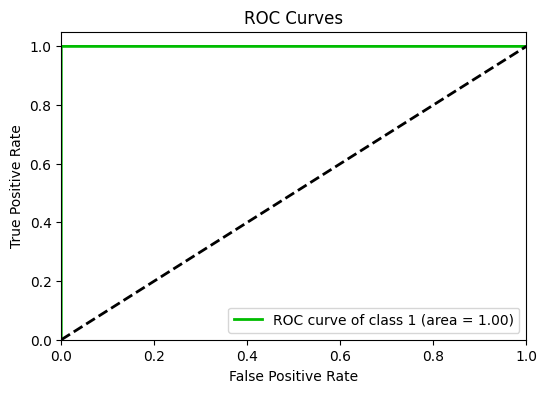

In [ ]:
skplt.metrics.plot_roc(y_validation, model.predict_proba(X_validation),classes_to_plot= 1,plot_micro= False, plot_macro = False, figsize=(6,4))
plt.show()

In [ ]:
cm_validation = confusion_matrix(y_validation, y_pred_val)
cm_validation

array([[2477,    0],
       [   0, 3020]])

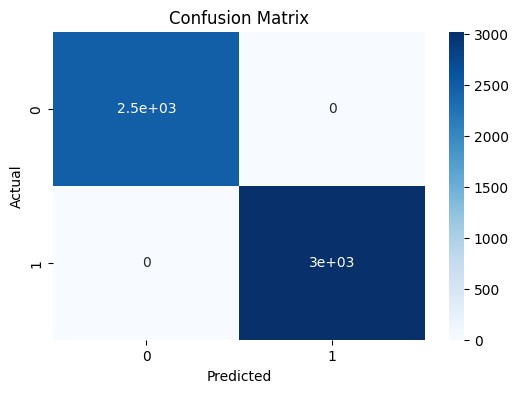

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(cm_validation, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Veo que si bien el colsample=0.8 puede parecer alto, al medir el modelo contra validation se ve que no realizó overfitting.

#Medición con test

In [ ]:
y_pred_test = model.predict(X_test)

In [ ]:
cm_test = confusion_matrix(y_test, y_pred_test)
cm_test

array([[2672,    1],
       [   0, 3434]])

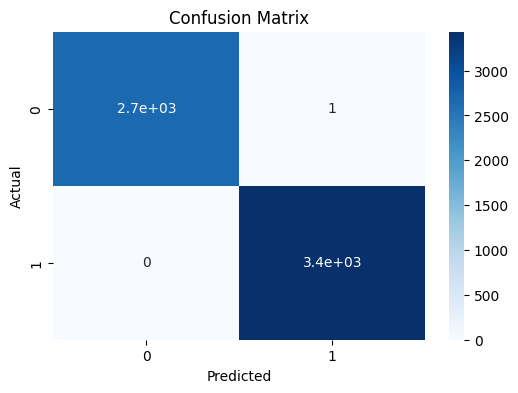

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(cm_test, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

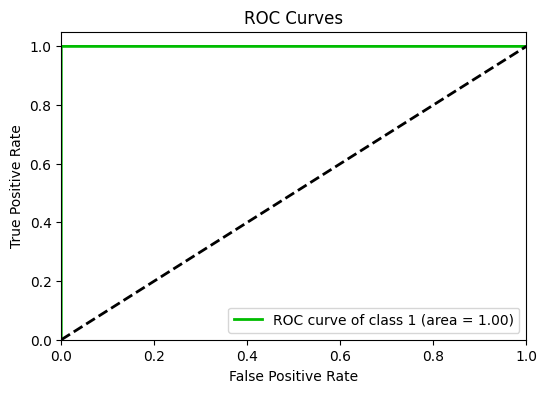

In [ ]:
skplt.metrics.plot_roc(y_test, model.predict_proba(X_test),classes_to_plot= 1,plot_micro= False, plot_macro = False, figsize = (6,4))
plt.show()

¿Cuál es el score en test? (guardar el csv con predicciones para entregarlo después)

¿Por qué cree que logro/no logro el mismo valor de AUC que con Random Forest?

In [ ]:
df_predic = pd.DataFrame({'y_test': y_test, 'y_predic_test': y_pred_test})
df_predic.to_csv('/content/drive/MyDrive/predicciones_xgb.csv')

Viendo las predicciones para test podemos notar que llega al mismo AUC-ROC que el RandomForest, esto se puede deber a que el modelo XGBClassifier se adaptó bien al problema o también puede ser que la búsqueda de hiperparámetros tuvo como objetivo el score AUC-ROC beneficiando el modelo. Cabe destacar que el mean-encoding puede llevar a un leak entre los datasets, pero, en este caso, al haber sido aplicado luego de que los datasets fueran divididos, no se pudo haber producido dicho leak lo que se refleja en las predicciones para test.